# Honeybee Data: Predicting Honey Production and Prices per Year

Final Project | December 16, 2020

<b>NetID:</b> Keri Tenerowicz (kmt225)

___

### Cleaning the Data

Rows with incomplete data were dropped. This option was chosen over filling each missing entry with a constant or the mean of its column to avoid possible outliers in trends among data for a certain category (state, stocks, etc).

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import kde
import pandas as pd
import numpy as np

df = pd.read_csv('honey.csv')
df = df[~df.State.str.contains('Other')]
df = df[~df.State.str.contains('US')]
df = df.dropna()
df = df.reset_index(drop=True)
dfAvg = df.copy()
dfAvg['AvgStock'] = dfAvg.groupby('Year')['Stocks December 15'].transform('mean')
dfAvg

,State,Honey producing colonies,Yield per colony,Production,Stocks December 15,Average price per pound,Value of production,Year,AvgStock
0,AL,41.0,20.0,820.0,33.0,0.54,443.0,1989,664.122449
1,AZ,78.0,45.0,3510.0,1158.0,0.55,1931.0,1989,664.122449
2,AR,34.0,61.0,2074.0,249.0,0.47,975.0,1989,664.122449
3,CA,560.0,34.0,19040.0,2857.0,0.49,9330.0,1989,664.122449
4,CO,50.0,66.0,3300.0,495.0,0.54,1782.0,1989,664.122449
...,...,...,...,...,...,...,...,...,...
1302,VA,5.0,39.0,195.0,49.0,7.51,1464.0,2019,1016.775000
1303,WA,81.0,35.0,2835.0,1191.0,2.12,6010.0,2019,1016.775000
1304,WV,6.0,37.0,222.0,47.0,4.50,999.0,2019,1016.775000
1305,WI,46.0,47.0,2162.0,692.0,2.99,6464.0,2019,1016.775000


___

### Problem
The first problem is "What is the value of honey production for each state?". This is a regression problem which aims to clarify a relationship between environmental factors (location, honey producing colonies, yield per colony, production, year) and financial factors (stocks on December 15th, average price per pound). I will build a supervised machine learning model (linear regression) to predict this using data from all columns except the 'Value of production' column. 

The second problem is "How does honey production vary by each state?". The second model will be a classification model (kNN classifier) that determines what state each set of values (row) the data was taken from. It will predict this based on the same set of columns + 'Value of production' - 'State'.

### Hypothesis
For the regression model, I believe that the following columns will be useful because they all influence the value of production based from either an envionmental or financial standpoint:

Environmental:
- State
- Honey producing colonies
- Yield per colony
- Production
- Year

Financial:
- Stocks December 15
- Average price per pound


For the classification model, I expect all columns except 'State' will be useful because that is as much data as possible for the predictions to include without the corresponding states.

___

### Scatterplot of Honey Producing Colonies vs. Value of Production

This scatterplot shows a slight positive trend among the data points. The overlapping near (0,0) indicates that there are many colonies which do not produce much honey or that there are few colonies at all in one area in one year. Thus, that area's value of production is lower for that year. As the number of honey producing colonies increases, there is a much higher variance and comparitively fewer data points, which makes the correlation a little more unclear. The trend is interesting because the correlation might be a result of human intervention to create a more stable environment for honeybees so more colonies could easily survive. As a result, people could have a higher yield of honey to harvest and sell. However, nothing can be concluded from this correlation alone.

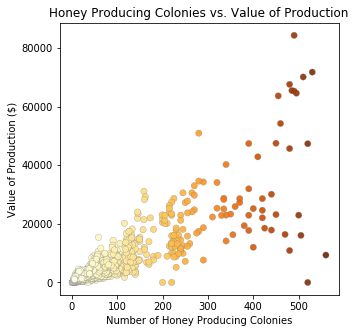

In [4]:
plt.title('Honey Producing Colonies vs. Value of Production')
plt.xlabel('Number of Honey Producing Colonies')
plt.ylabel('Value of Production ($)')
x = df['Honey producing colonies']
y = df['Value of production']
plt.scatter(x, y, s=40, c=x, cmap="YlOrBr", alpha=0.9, edgecolors="grey", linewidth=0.3)
plt.gcf().set_size_inches((5, 5)) 

plt.show()

___

### Average Stocks on December 15th of Each Year

This line graph shows the average of the honey stock prices for all states given each year from 1989 to 2019. Looking at this data, we would expect that the model which predicts the feature 'Value of production' would increase when this feature, stock prices, increases and follow when it decreases. When taking into account all other features that will be used to predict the value of production, there may not be as strong of a correlation.

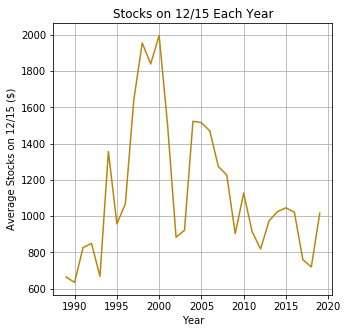

In [5]:
plt.plot(dfAvg['Year'].to_numpy(), dfAvg['AvgStock'].to_numpy(), color='darkgoldenrod')
plt.title('Stocks on 12/15 Each Year')
plt.xlabel('Year')
plt.ylabel('Average Stocks on 12/15 ($)')
plt.grid(True)
plt.gcf().set_size_inches((5, 5))

plt.show()

___

### Heap Map of Features's Correlation

This correlation matrix represented in a heat map shows how closely each feature is correlated to another. The column and row for 'Value of production' are most relevant to the models below because the features that correlate closely with it (darker colors) may have a larger influence on the predictions than other features.

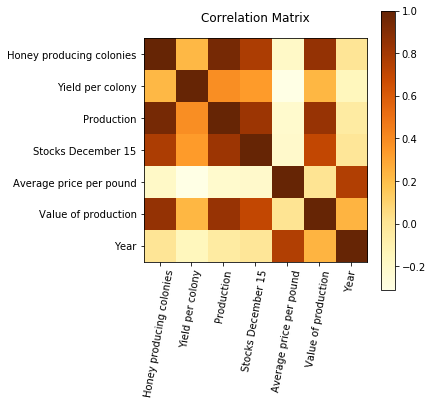

In [7]:
correlation = df.corr()
cMat = plt.matshow(correlation, cmap = 'YlOrBr')

length = range(len(correlation.columns))
plt.xticks(length, correlation.columns, rotation=80)
plt.gca().xaxis.tick_bottom()
plt.yticks(length, correlation.columns)

plt.colorbar(cMat)
plt.title('Correlation Matrix')
plt.gcf().set_size_inches((5, 5))

plt.show()

___

### Linear Regression

The linear regression model is used for data that is continuous. Here, it is used to predict the value of production, which is represented in dollars. All the input information is also qualitative except for the state where the data was taken, which was transformed form a categorical variable to a quatitative variable. The training score was ~0.87, which means that the model captured training set relationship with 87% acuracy. Similarly, the testing score was ~0.80, meaning that the model predicted the value of production fairly accurately.

In [13]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder
from pandas import get_dummies

dfDummies = df.copy()

data = asarray(dfDummies['State'])
s = pd.Series(data)
states_cat = pd.get_dummies(s)

dfDummies = dfDummies.drop(['State'], axis=1)
dfDummies = pd.concat([states_cat, dfDummies], axis=1)
dfDummies

,AL,AR,AZ,CA,CO,CT,DE,FL,GA,HI,...,WI,WV,WY,Honey producing colonies,Yield per colony,Production,Stocks December 15,Average price per pound,Value of production,Year
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,41.0,20.0,820.0,33.0,0.54,443.0,1989
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,78.0,45.0,3510.0,1158.0,0.55,1931.0,1989
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,34.0,61.0,2074.0,249.0,0.47,975.0,1989
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,560.0,34.0,19040.0,2857.0,0.49,9330.0,1989
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,50.0,66.0,3300.0,495.0,0.54,1782.0,1989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,0,0,0,0,0,0,0,0,0,0,...,0,0,0,5.0,39.0,195.0,49.0,7.51,1464.0,2019
1303,0,0,0,0,0,0,0,0,0,0,...,0,0,0,81.0,35.0,2835.0,1191.0,2.12,6010.0,2019
1304,0,0,0,0,0,0,0,0,0,0,...,0,1,0,6.0,37.0,222.0,47.0,4.50,999.0,2019
1305,0,0,0,0,0,0,0,0,0,0,...,1,0,0,46.0,47.0,2162.0,692.0,2.99,6464.0,2019


In [14]:
X = dfDummies.drop(['Value of production'], axis=1)
Y = pd.DataFrame(dfDummies,columns=['Value of production'])
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)

#print(predictions)
print("Training Score:", model.score(x_train,y_train))
print("Testing Score:", model.score(x_test,y_test))

Training Score: 0.8689304065559953
Testing Score: 0.8003300234054468


___

### kNN

The kNN (k-nearest neighbors) model is used for classification. The classification here is which state each datapoint comes from. For the state kNN model, the accuracy score and training score are ~0.37 and ~0.24 respectively. These are relatively low, so a baseline model was created to show that the model had a huge effect in the prediction of scores. For the year kNN model, the accuracy score and training score are 1.0 and ~0.10 respectively. The high training score shows that the model fit very well with the data, while the low accuracy score means that it will not generalize well to other sets of similar data. The state kNN model is more applicable to other datasets in comparison.

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

df

,State,Honey producing colonies,Yield per colony,Production,Stocks December 15,Average price per pound,Value of production,Year
0,AL,41.0,20.0,820.0,33.0,0.54,443.0,1989
1,AZ,78.0,45.0,3510.0,1158.0,0.55,1931.0,1989
2,AR,34.0,61.0,2074.0,249.0,0.47,975.0,1989
3,CA,560.0,34.0,19040.0,2857.0,0.49,9330.0,1989
4,CO,50.0,66.0,3300.0,495.0,0.54,1782.0,1989
...,...,...,...,...,...,...,...,...
1302,VA,5.0,39.0,195.0,49.0,7.51,1464.0,2019
1303,WA,81.0,35.0,2835.0,1191.0,2.12,6010.0,2019
1304,WV,6.0,37.0,222.0,47.0,4.50,999.0,2019
1305,WI,46.0,47.0,2162.0,692.0,2.99,6464.0,2019


In [16]:
X = df.drop('State', axis=1)
Y = df['State']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = KNeighborsClassifier(13) # default k=5
model.fit(x_train, y_train)
predictions = model.predict(x_test)

#print(predictions)
print("Training Score:", model.score(x_train,y_train))
print("Accuracy Score:", accuracy_score(y_test, predictions))

Training Score: 0.35311004784688993
Accuracy Score: 0.2862595419847328


The following cell was used to calculate the accuracy score over 20 different values for the number of nearest neighbors used (k). This was run after the State kNN and the Year kNN, then each model was edited to use the value of k that corresponded to the highest accuracy.

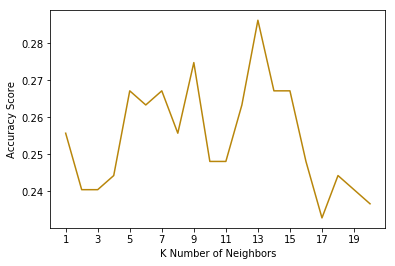

In [25]:
accuracy = []
for k in range(1, 21):
    model = KNeighborsClassifier(k)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    accuracy.append(accuracy_score(predictions, y_test))
    
plt.plot(range(1, 21), accuracy, color='darkgoldenrod')
plt.xticks(range(1, 21, 2), range(1, 21, 2))
plt.xlabel("K Number of Neighbors")
plt.ylabel("Accuracy Score")
plt.show()

Below, we create a baseline array of predictions to compare to our model. The baseline array is filled with random state abbreviations from the df['State'] column. The percent improvement is then calculated. A number larger than one often appears, showing a huge improvement using the kNN model versus the baseline array. Thus, although the model accuracy score is low, it is a significant improvement over using no model at all.

In [24]:
accuracy = accuracy_score(y_test, predictions)
print('Accuracy:',accuracy)

y_train.describe()
y_test.describe()
base_array = np.random.choice(list(df['State'].values), size=(262))
#print(base_array)

baseline = accuracy_score(y_test, base_array)
print('Baseline:',baseline)
improvement = (accuracy - baseline) / baseline
print('Improvment:', improvement)

Accuracy: 0.2366412213740458
Baseline: 0.022900763358778626
Improvment: 9.333333333333334


Since the scores were low for the state kNN model, maybe looking at the data of one state will help show why:

In [32]:
dfAL = df[df['State'].str.contains("AL")]
dfAL

,State,Honey producing colonies,Yield per colony,Production,Stocks December 15,Average price per pound,Value of production,Year
0,AL,41.0,20.0,820.0,33.0,0.54,443.0,1989
49,AL,29.0,38.0,1102.0,143.0,0.55,606.0,1990
98,AL,20.0,25.0,500.0,65.0,0.62,310.0,1991
142,AL,25.0,41.0,1025.0,113.0,0.59,605.0,1992
186,AL,19.0,45.0,855.0,103.0,0.67,573.0,1993
230,AL,18.0,50.0,900.0,99.0,0.50,450.0,1994
274,AL,16.0,58.0,928.0,28.0,0.69,640.0,1995
318,AL,16.0,64.0,1024.0,102.0,0.86,881.0,1996
362,AL,14.0,66.0,924.0,92.0,0.81,748.0,1997
405,AL,16.0,71.0,1136.0,159.0,0.72,818.0,1998


This shows a clear decrease in 'Honey producing colonies' and increase in 'Average price per pound' in order of the year for this state. We will now run  kNN classifier to predict the year data was taken because that seems to have a higher absolute value of correlation with other data.

In [35]:
X = dfDummies.drop('Year', axis=1)
Y = dfDummies['Year']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = KNeighborsClassifier(6) # default k=5
model.fit(x_train, y_train)
predictions = model.predict(x_test)

#print(predictions)
print("Training Score:", model.score(x_train,y_train))
print("Accuracy Score:", accuracy_score(y_test, predictions))

Training Score: 0.3119617224880383
Accuracy Score: 0.10687022900763359


For the kNN predicting years, the accuracy score is even lower. This may suggest that there is a low connection between features used to generate the predictions and the real data being predicted. The training score, however, is very high, which means that it fit the prediction data well.

___

### Comparison of Linear Regression & kNN


Both the accuracy scores of the kNN models are lower than those of the regression model. However, the order of the training scores from lowest to highest is state kNN, regression model, year kNN. 

Things that worked well may have been that all models had many columns of data to predict their results from and that there were many entries for each column. Things that may not have worked well were that there seemed to be other factors which influenced those used in the models, such as environmental variables like weather or the jobs available for people contributing to this data. This may have caused the accuracy and training scores to lower.